**Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

**Data Preperation**

In [2]:


labels = ['glioma', 'meningioma','pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 150


for label in labels:
    trainPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)
print("x_train shape : ",x_train.shape)
print("x_test shape : ",x_test.shape)
print("y_train shape : ",y_train.shape)
print("y_test shape : ",y_test.shape)

100%|██████████| 300/300 [00:02<00:00, 112.73it/s]


x_train shape :  (4117, 150, 150, 3)
x_test shape :  (906, 150, 150, 3)
y_train shape :  (4117,)
y_test shape :  (906,)


In [3]:
pd.Series(y_train).value_counts()

2    1457
1    1339
0    1321
dtype: int64

0


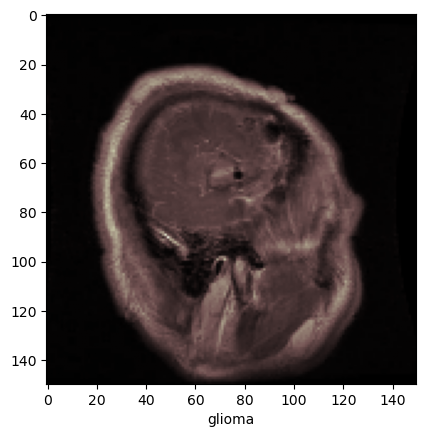

In [4]:
def plot_img(X,y,index):
    plt.imshow(X[index])
    plt.xlabel(labels[y[index]])
    print(y[index])

plot_img(x_train,y_train,0)

In [5]:
x_train, y_train = shuffle(x_train,y_train, random_state=1) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=1) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1236, 150, 150, 3)


In [6]:
# Apply data augmentation to the training data
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                             zoom_range=0.2, horizontal_flip=True)

datagen.fit(x_train)

In [7]:
base_model = InceptionV3(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

87910968/87910968 [==============================] - 5s 0us/step


In [8]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

#compile our model.
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________


In [9]:
history=model.fit(datagen.flow(x_train, y_train, batch_size=16), epochs=20,
                    validation_data=(x_val, y_val))

Epoch 1/20
181/181 [==============================] - 69s 132ms/step - loss: 0.4921 - accuracy: 0.8004 - val_loss: 0.3566 - val_accuracy: 0.8859
Epoch 2/20
181/181 [==============================] - 19s 106ms/step - loss: 0.2450 - accuracy: 0.9104 - val_loss: 0.2379 - val_accuracy: 0.9312
Epoch 3/20
181/181 [==============================] - 20s 113ms/step - loss: 0.1745 - accuracy: 0.9361 - val_loss: 0.1780 - val_accuracy: 0.9498
Epoch 4/20
181/181 [==============================] - 19s 104ms/step - loss: 0.1438 - accuracy: 0.9507 - val_loss: 0.1868 - val_accuracy: 0.9426
Epoch 5/20
181/181 [==============================] - 20s 110ms/step - loss: 0.1283 - accuracy: 0.9566 - val_loss: 0.1372 - val_accuracy: 0.9474
Epoch 6/20
181/181 [==============================] - 20s 108ms/step - loss: 0.0829 - accuracy: 0.9681 - val_loss: 0.2092 - val_accuracy: 0.9450
Epoch 7/20
181/181 [==============================] - 19s 105ms/step - loss: 0.0968 - accuracy: 0.9674 - val_loss: 0.1321 - val_ac

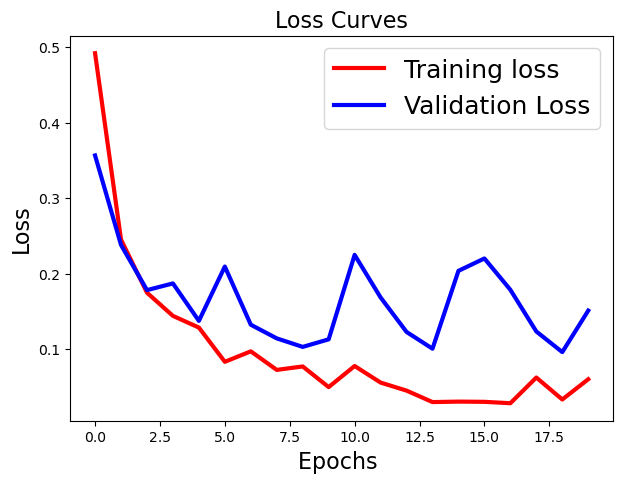

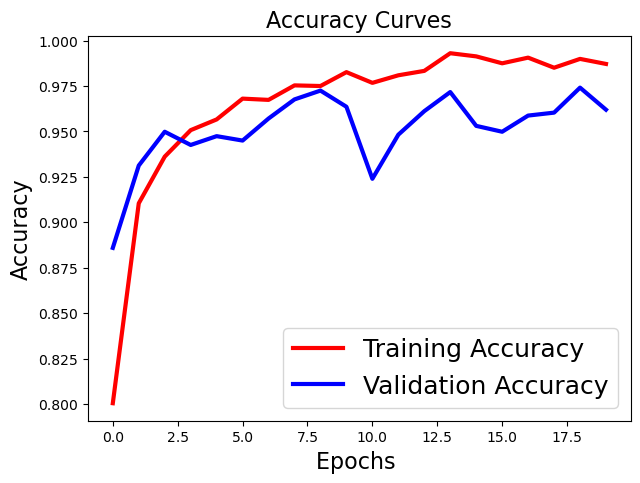

In [11]:
#Plot the Loss Curves
plt.figure(figsize=[7,5])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[7,5])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

29/29 [==============================] - 2s 54ms/step - loss: 0.1425 - accuracy: 0.9702
Test Loss: 0.14254310727119446
Test Accuracy: 0.9701986908912659


29/29 [==============================] - 3s 29ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       300
           1       0.98      0.94      0.96       306
           2       0.94      1.00      0.97       300

    accuracy                           0.97       906
   macro avg       0.97      0.97      0.97       906
weighted avg       0.97      0.97      0.97       906



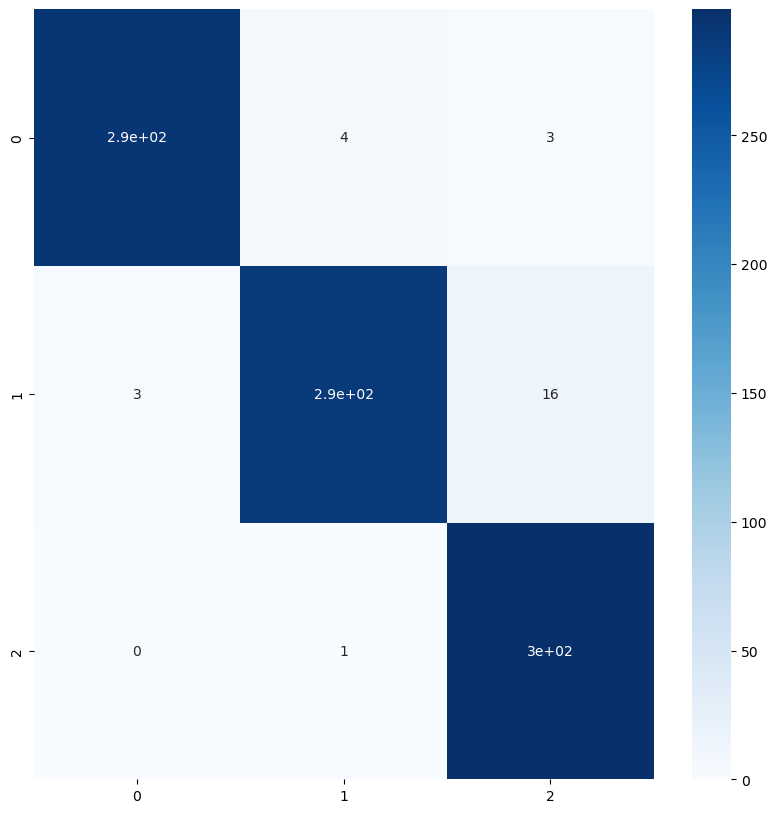

In [13]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [14]:
 model.save('model_InceptionV3.h5')